# Full stack data science finance (small) project

## Extract

See excel file

## Load libraries

In [2]:
import warnings; warnings.filterwarnings('ignore')

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action = 'ignore', category = DataConversionWarning)

import matplotlib.pyplot as plt; import seaborn as sns; import plotly as py; import plotly.graph_objs as go
import pandas as pd; import numpy as np; import scipy as sy

from sklearn.pipeline import Pipeline; from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans; from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier; from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier; from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier; from sklearn.metrics import confusion_matrix, classification_report

## Load raw data

In [4]:
workbook, window, ticker_market = pd.ExcelFile('../data-raw/pullit.xlsm'), 252, 'RAY Index'
tickers = pd.read_excel(workbook, sheet_name = 'update', usecols = 'D', dtype = 'str').ticker.values

## Tidy up

In [5]:
static = pd.read_excel(workbook, sheet_name = 'update', usecols = 'D:G')
static = static.loc[static['ticker'] != ticker_market].set_index('ticker')

historical = {ticker: pd.read_excel(workbook, skiprows = 1, sheet_name  = ticker) for ticker in tickers}
historical = pd.concat(historical.values(), keys = historical.keys()).dropna(subset = ['Date'])\
    .reset_index().drop('level_1', axis = 1)
historical.rename(columns = {'level_0': 'ticker', 'Date': 'date'}, inplace = True)
historical.set_index(['ticker', 'date'], inplace = True)

## Transform

### 1-year market betas

#### Dataset

In [62]:
betas = historical[['PX_LAST']].unstack('ticker').xs('PX_LAST', axis = 1, drop_level = True)\
    .pct_change().dropna().iloc[-window:, ]

#### Values

In [63]:
market = betas[ticker_market]; betas.drop(ticker_market, axis = 1, inplace = True)

betas = betas.apply(lambda stock: sy.stats.linregress(x = market, y = stock).slope, axis = 0)
betas = pd.DataFrame(betas).reset_index(); betas.columns = ['ticker', 'beta']

#### Plot

In [64]:
py.offline.init_notebook_mode(connected = True)

data = [go.Histogram(x = betas['beta'], autobinx = False, xbins = dict(start = 0, end = 2, size = 0.025))]
py.offline.iplot(data)

### 1-year rolling market betas

#### Values

In [65]:
betas = historical[['PX_LAST']].unstack('ticker').xs('PX_LAST', axis = 1, drop_level = True)\
    .pct_change().dropna(how = 'all')

market = betas[ticker_market]; betas.drop(ticker_market, axis = 1, inplace = True)

betas = {betas.index[i].strftime('%Y-%m-%d'): betas.iloc[(i - window):i, ]\
         .apply(lambda column: sy.stats.linregress(x = market[(i - window):i], y = column).slope, axis = 0)
         for i in range(window, len(betas))}
betas = pd.DataFrame(pd.concat(betas, ignore_index = False)).reset_index()\
    .rename(columns = {'level_0': 'date', 0: 'beta'}).dropna()\
    .set_index(['date', 'ticker']).unstack('ticker').\
    xs('beta', axis = 1, drop_level = True)

#### Plot

<IPython.core.display.Javascript object>


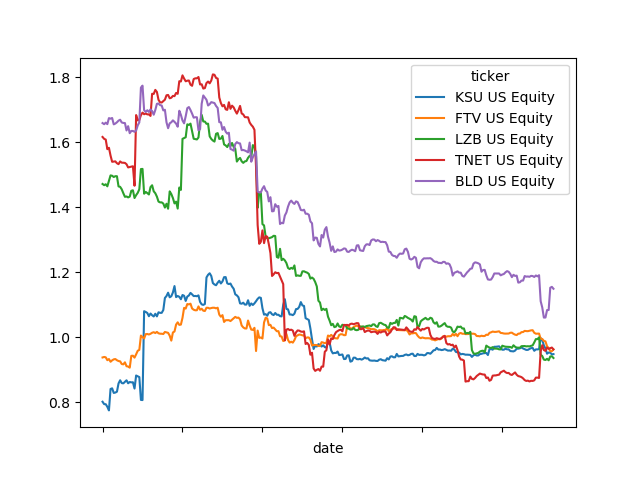

In [66]:
%matplotlib notebook

tickers = betas.columns.values[np.random.randint(low = 0, high = len(betas.columns) - 1, size = 5)]
betas[tickers].plot()

### Ratios

#### Values

In [67]:
ratios = historical.groupby(level = 'ticker').last().reset_index()\
    .loc[:, ['ticker', 'PX_LAST', 'BOOK_VAL_PER_SH', 'TRAIL_12M_EPS', 
             'TRAIL_12M_DVD_PER_SH', 'SHORT_AND_LONG_TERM_DEBT', 'TOTAL_EQUITY']]

ratios['price / book'] = ratios['PX_LAST'] / ratios['BOOK_VAL_PER_SH']
ratios['price / earnings'] = ratios['PX_LAST'] / ratios['TRAIL_12M_EPS']
ratios['dividend yield'] = ratios['TRAIL_12M_DVD_PER_SH'] / ratios['PX_LAST']
ratios['debt / equity'] = ratios['SHORT_AND_LONG_TERM_DEBT'] / ratios['TOTAL_EQUITY']
ratios = ratios[['ticker', 'price / book', 'price / earnings', 'dividend yield', 'debt / equity']]
ratios.set_index('ticker', inplace = True)

#### Plot

<IPython.core.display.Javascript object>


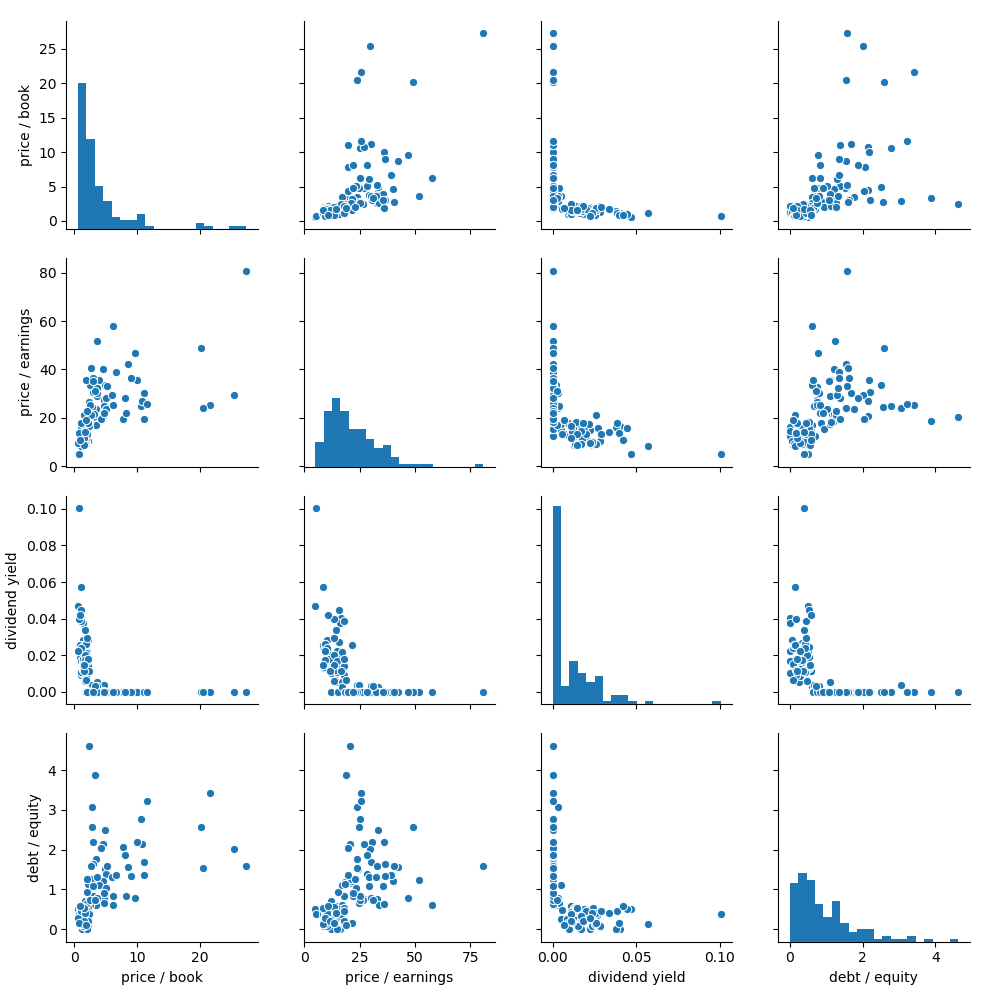

In [68]:
%matplotlib notebook

data = ratios.dropna().copy()
sns.pairplot(data, diag_kind = 'hist', diag_kws = dict(bins = 20))

<IPython.core.display.Javascript object>


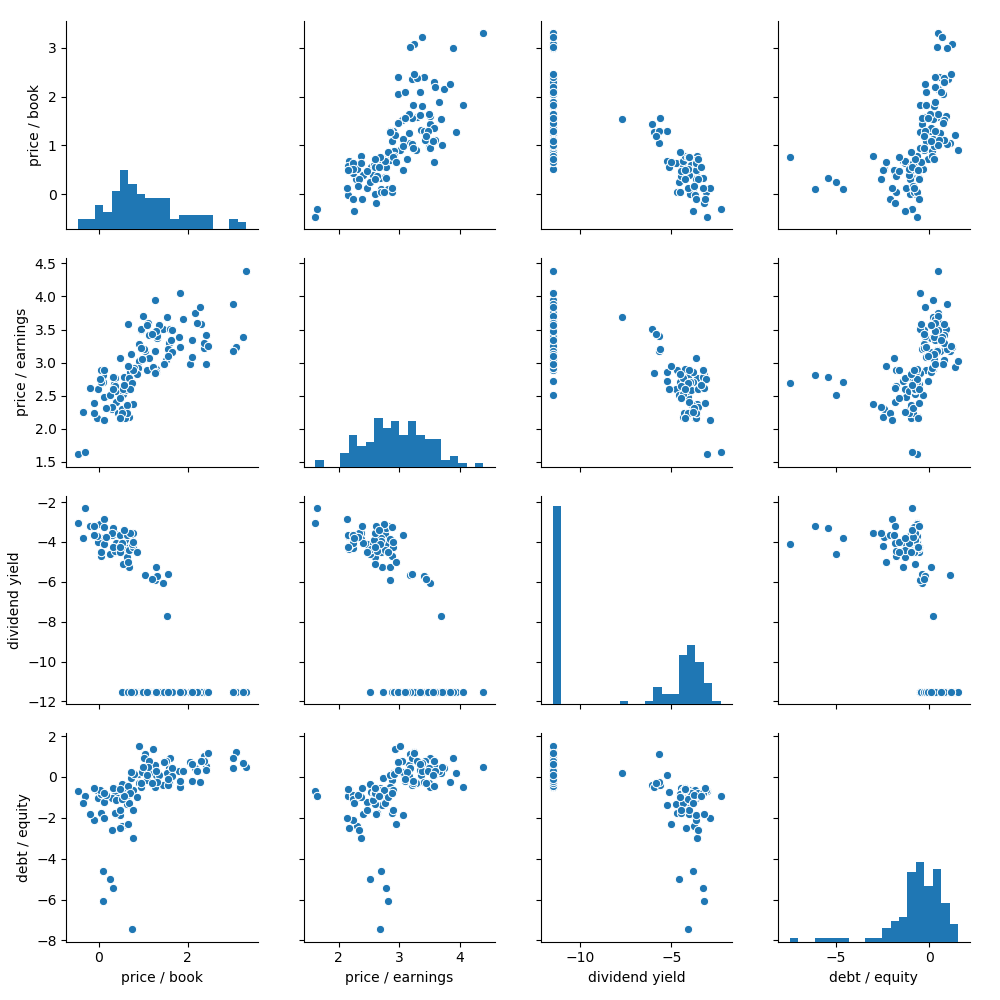

In [11]:
%matplotlib notebook

data.replace(to_replace = 0, value = 0.00001, inplace = True)
sns.pairplot(np.log(data), diag_kind = 'hist', diag_kws = {'bins' : 20})

## Model

### Cluster analysis

#### Dataset

In [69]:
scaled = StandardScaler()
scaled = scaled.fit(ratios.dropna().values).transform(ratios.dropna().values)

#### Dendogram

<IPython.core.display.Javascript object>


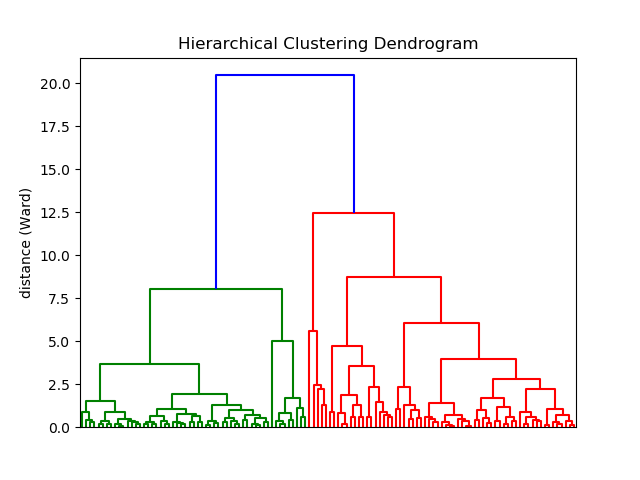

Text(0, 0.5, 'distance (Ward)')

In [70]:
%matplotlib notebook

distance = sy.cluster.hierarchy.linkage(scaled, 'ward')
sy.cluster.hierarchy.dendrogram(distance, color_threshold = 15, no_labels = True)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('distance (Ward)')

#### k-means with 2 clusters

In [71]:
clusters = KMeans(n_clusters = 2); clusters.fit(scaled)
clusters = pd.DataFrame(data = clusters.labels_, index = ratios.dropna().index, columns = ['class'])

#### Cluster characteristics

In [72]:
data = pd.merge(clusters, ratios.dropna(), left_index = True, right_index = True)
data.groupby('class').mean()

,price / book,price / earnings,dividend yield,debt / equity
class,,,,
0,6.464222,29.777130,0.000344,1.548743
1,1.562599,13.000504,0.021964,0.335101


#### Name classes in dataset

In [73]:
data.replace({'class': {0: 'value', 1: 'growth'}}, inplace = True)

#### Explore class distribution

<IPython.core.display.Javascript object>


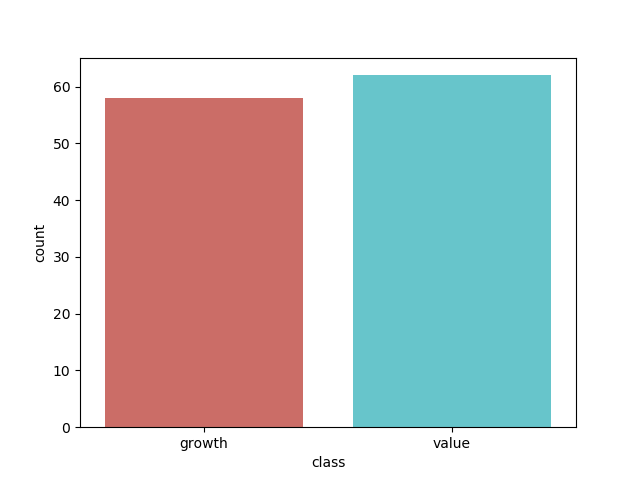

In [74]:
%matplotlib notebook

sns.countplot(x = 'class', data = data, palette = 'hls')

### Classification

#### Dataset

In [75]:
betas = pd.DataFrame(data = betas.iloc[-1, :].values, index = betas.iloc[-1, :].index, columns = ['market beta'])
data = pd.merge(data, betas, left_index = True, right_index = True)
data = pd.merge(data, static, left_index = True, right_index = True)
data.dropna(inplace = True)

X_train, X_test, y_train, y_test = train_test_split(data.drop('class', axis = 1), data['class'], 
                                                    test_size = 0.25, random_state = 4321)

#### Logistic regression

##### Basic model

In [76]:
pipe = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression())])

###### Assess training set performance

In [77]:
pipe.fit(X_train, y_train)

confusion = confusion_matrix(y_train, pipe.predict(X_train))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_train, pipe.predict(X_train), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[48  0]
 [ 0 39]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      1.00      1.00        48
      growth       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87




###### Assess test set performance

In [78]:
confusion = confusion_matrix(y_test, pipe.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_test, pipe.predict(X_test), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[ 9  1]
 [ 0 19]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      0.90      0.95        10
      growth       0.95      1.00      0.97        19

   micro avg       0.97      0.97      0.97        29
   macro avg       0.97      0.95      0.96        29
weighted avg       0.97      0.97      0.97        29




##### k nearest neighbours

###### Fit model

In [80]:
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'roc_auc')

###### Exlore model selection output

In [81]:
grid.fit(X_train, y_train)
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'knn__n_neighbors': 4}


###### Assess training set performance

In [82]:
confusion = confusion_matrix(y_train, grid.predict(X_train))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_train, grid.predict(X_train), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[48  0]
 [ 1 38]]

Classification report:
              precision    recall  f1-score   support

       value       0.98      1.00      0.99        48
      growth       1.00      0.97      0.99        39

   micro avg       0.99      0.99      0.99        87
   macro avg       0.99      0.99      0.99        87
weighted avg       0.99      0.99      0.99        87




###### Assess test set performance

In [83]:
confusion = confusion_matrix(y_test, grid.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_test, grid.predict(X_test), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[ 9  1]
 [ 0 19]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      0.90      0.95        10
      growth       0.95      1.00      0.97        19

   micro avg       0.97      0.97      0.97        29
   macro avg       0.97      0.95      0.96        29
weighted avg       0.97      0.97      0.97        29




##### Support vector machines

###### Fit model

In [84]:
pipe = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel = 'linear'))])

param_grid = {'svm__C': [1, 2, 3, 4, 5], 'svm__gamma': [0.1, 0.2, 0.3, 0.4, 0.5]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'roc_auc')

###### Exlore model selection output

In [85]:
grid.fit(X_train, y_train)
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'svm__C': 1, 'svm__gamma': 0.1}


###### Assess training set performance

In [86]:
confusion = confusion_matrix(y_train, grid.predict(X_train))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_train, grid.predict(X_train), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[48  0]
 [ 0 39]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      1.00      1.00        48
      growth       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87




###### Assess test set performance

In [87]:
confusion = confusion_matrix(y_test, grid.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_test, grid.predict(X_test), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[ 9  1]
 [ 0 19]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      0.90      0.95        10
      growth       0.95      1.00      0.97        19

   micro avg       0.97      0.97      0.97        29
   macro avg       0.97      0.95      0.96        29
weighted avg       0.97      0.97      0.97        29




##### Decision tree

###### Fit model

In [99]:
pipe = Pipeline([("scaler", StandardScaler()), ("tree", DecisionTreeClassifier())])

param_grid = {'tree__max_depth': [1, 2, 3, 4, 5]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'roc_auc')

###### Exlore model selection output

In [100]:
grid.fit(X_train, y_train)
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'tree__max_depth': 2}


###### Assess training set performance

In [101]:
confusion = confusion_matrix(y_train, grid.predict(X_train))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_train, grid.predict(X_train), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[48  0]
 [ 0 39]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      1.00      1.00        48
      growth       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87




###### Assess test set performance

In [90]:
confusion = confusion_matrix(y_test, grid.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_test, grid.predict(X_test), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[ 9  1]
 [ 0 19]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      0.90      0.95        10
      growth       0.95      1.00      0.97        19

   micro avg       0.97      0.97      0.97        29
   macro avg       0.97      0.95      0.96        29
weighted avg       0.97      0.97      0.97        29




##### Random forest

###### Fit model

In [91]:
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestClassifier())])

param_grid = {'forest__n_estimators': [1, 2, 3, 4, 5]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'roc_auc')

###### Exlore model selection output

In [92]:
grid.fit(X_train, y_train)
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'forest__n_estimators': 4}


###### Assess training set performance

In [93]:
confusion = confusion_matrix(y_train, grid.predict(X_train))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_train, grid.predict(X_train), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[48  0]
 [ 1 38]]

Classification report:
              precision    recall  f1-score   support

       value       0.98      1.00      0.99        48
      growth       1.00      0.97      0.99        39

   micro avg       0.99      0.99      0.99        87
   macro avg       0.99      0.99      0.99        87
weighted avg       0.99      0.99      0.99        87




###### Assess test set performance

In [94]:
confusion = confusion_matrix(y_test, grid.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_test, grid.predict(X_test), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[ 9  1]
 [ 1 18]]

Classification report:
              precision    recall  f1-score   support

       value       0.90      0.90      0.90        10
      growth       0.95      0.95      0.95        19

   micro avg       0.93      0.93      0.93        29
   macro avg       0.92      0.92      0.92        29
weighted avg       0.93      0.93      0.93        29




##### Neural network

###### Fit model

In [95]:
pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(activation = 'relu'))])

param_grid = {'mlp__solver': ['lbfgs'], 'mlp__alpha': 10.0 ** -np.arange(1, 10), 
              'mlp__hidden_layer_sizes': np.arange(10, 15)}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'roc_auc')

###### Exlore model selection output

In [96]:
grid.fit(X_train, y_train)
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 10, 'mlp__solver': 'lbfgs'}


###### Assess training set performance

In [97]:
confusion = confusion_matrix(y_train, grid.predict(X_train))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_train, grid.predict(X_train), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[48  0]
 [ 0 39]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      1.00      1.00        48
      growth       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87




###### Assess test set performance

In [98]:
confusion = confusion_matrix(y_test, grid.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

print("Classification report:\n{}\n".format(classification_report(y_test, grid.predict(X_test), 
                                                                  target_names = ["value", "growth"])))

Confusion matrix:
[[ 9  1]
 [ 0 19]]

Classification report:
              precision    recall  f1-score   support

       value       1.00      0.90      0.95        10
      growth       0.95      1.00      0.97        19

   micro avg       0.97      0.97      0.97        29
   macro avg       0.97      0.95      0.96        29
weighted avg       0.97      0.97      0.97        29


